In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
import nltk
import json

import tensorflow as tf

from functions import sample_mean
from lists import stop_words,noise
from plots import model_plots
import string
import warnings
import os
os.chdir('/home/ubuntu/Notebooks')

%matplotlib inline
punctuation = set(string.punctuation)
sws = stop_words().get_sws()
noise = noise().get_noise()
keras = tf.keras
pd.options.display.max_rows = 200
pd.set_option('max_colwidth', 200)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',500)

ta_data = pd.read_pickle('data/ta/ta_data2.pickle').replace(1.0,2.0).replace(0.0,2.0).sample(frac=.5,random_state=3)
ta_data.columns = ['index', 'id', 'offering_id', 'text', 'ratings_overall', 'language']
ta_data = ta_data[ta_data['language'] == 'en']

In [49]:
ta_data['ratings_overall'].value_counts()

5.0    39506
4.0    30965
2.0    12957
3.0    12937
Name: ratings_overall, dtype: int64

In [50]:
idx_2 = ta_data[ta_data['ratings_overall'] == 2].index
idx_3 = ta_data[ta_data['ratings_overall'] == 3].index
idx_4 = ta_data[ta_data['ratings_overall'] == 4].index
idx_5 = ta_data[ta_data['ratings_overall'] == 5].index

In [51]:
np.random.seed(10)
sample_idx_2 = np.random.choice(idx_2,replace=False,size=12937)
sample_idx_3 = np.random.choice(idx_3,replace=False,size=12937)
sample_idx_4 = np.random.choice(idx_4,replace=False,size=12937)
sample_idx_5 = np.random.choice(idx_5,replace=False,size=12937)

ta_data = pd.concat([ta_data.loc[sample_idx_2],
           ta_data.loc[sample_idx_3],
           ta_data.loc[sample_idx_4],
           ta_data.loc[sample_idx_5]],axis=0)


51748


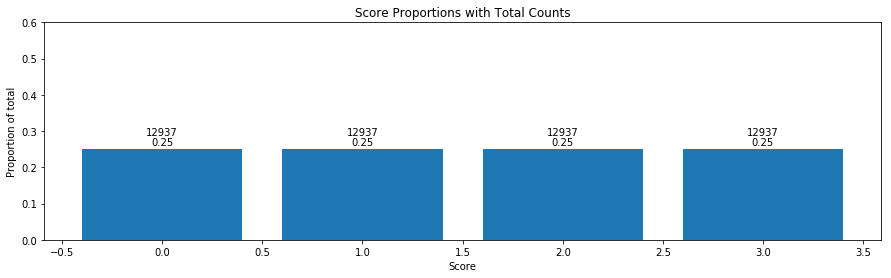

In [57]:
plt.figure(figsize=(15,4))
ta_data['ratings_overall'] = ta_data['ratings_overall'].astype(int)

score_counts = ta_data['ratings_overall'].value_counts().sort_index()
review_distribution = score_counts/score_counts.sum()

plt.bar(range(review_distribution.shape[0]),review_distribution.sort_index().values)
for i,v in enumerate(review_distribution.sort_index().values):
    plt.text(i,v+.01,round(v,2),horizontalalignment='center')
    plt.text(i,v+.04,score_counts.iloc[i],horizontalalignment='center')
plt.title('Score Proportions with Total Counts')
plt.xlabel('Score')
plt.ylabel('Proportion of total')

plt.ylim(0,.6)
print(ta_data.shape[0])

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
nb = MultinomialNB()


X = ta_data['text']
X_metrics = ta_data['text']
y = ta_data['ratings_overall']

X_char_count = X_metrics.apply(len)
X_word_count = X_metrics.apply(lambda x: len(x.split()))
X_word_density = X_char_count/X_word_count
X_punctuation_count = X_metrics.apply(lambda x: len([_ for _ in x if _ in set(string.punctuation)]))
X_title_word_count = X_metrics.apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
X_uppercase_count = X_metrics.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

count = CountVectorizer(stop_words=sws,ngram_range=(1,1),max_features=20000)
X = count.fit_transform(X).toarray()

X = np.c_[X,X_char_count,
                       X_word_count,
                       X_word_density,
                       X_punctuation_count,
                       X_title_word_count,
                       X_uppercase_count]

x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=.15)

nb.fit(x_train,y_train)
ypred = pd.Series(nb.predict(x_test),index=y_test.index)
ypred_train = nb.predict(x_train)
# print('Test: ',(ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
# print('Train: ',(ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())
mnb_plots = model_plots()


mnb_plots.model_to_actual_plot(ta_data,
                              y_test,
                              ypred,
                              'Actual',
                              'Multinomial with Custom Stop Words Naive Bayes Score',
                              'MNB to Actual Score Distribution')
mnb_plots.error_plot(ta_data,ypred,y_test,'Error','total count')

accuracy_mnb = (ypred == y_test).mean().round(3)
distribution_error_mnb = (ypred.sub(y_test).abs().sum()/y_test.sum()).round(3)
error_accuracy_mnb = ((y_test.sub(ypred)).lt(2) & (y_test.sub(ypred)).gt(-2)).mean().round(3)
training_accuracy_mnb = round((ypred_train - y_train).value_counts().max()/(ypred_train - y_train).value_counts().sum(),2)

print('Training Accuracy',training_accuracy_mnb)
print('mnb Accuracy',accuracy_mnb)
print('mnb Distribution Accuracy',1-distribution_error_mnb)
print('mnb Error Accuracy',error_accuracy_mnb.round(3))

MemoryError: 

## LSTM

In [58]:
from gensim.models.keyedvectors import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz',
                                                 binary=True,
                                                 limit=2000000)

In [59]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer


X = ta_data['text']
y = ta_data['ratings_overall']
x_train,x_valid,y_train,y_valid = train_test_split(X,y,test_size=.15)

maxlen = 150
training_samples = x_train.shape[0]
validation_samples = x_valid.shape[0]
batch_size = 25
embedding_dims = 300
epochs = 2
embedding_dim = 300

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk

token = Tokenizer(char_level=False,lower=True)
token.fit_on_texts(X)
# tokenize.texts_to_sequences(x_train.iloc[0])
x_train_seq = pad_sequences(token.texts_to_sequences(x_train),maxlen=maxlen)
x_valid_seq = pad_sequences(token.texts_to_sequences(x_valid),maxlen=maxlen)

word_index = token.word_index
max_words = len(word_index)

In [60]:
embedding_matrix = np.zeros((max_words,embedding_dims))
for word,i in word_index.items():
    if i < max_words:
        try:
            embedding_vector = word_vectors.get_vector(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        except:
            pass

In [61]:
(embedding_matrix.sum(axis=1) == 0).sum()

26349

In [69]:
ohe = OneHotEncoder()
y_train_new = ohe.fit_transform(y_train.values.reshape(-1,1))
y_valid_new = ohe.fit_transform(y_valid.values.reshape(-1,1))

# x_valid_seq2 = x_valid_seq.reshape(x_valid_seq.shape[0],x_valid_seq.shape[1],1)
# x_train_seq2 = x_train_seq.reshape(x_train_seq.shape[0],x_train_seq.shape[1],1)

In [64]:
x_valid_seq.shape

(7763, 150)

In [66]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding

model2 = Sequential()
model2.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model2.add(Dropout(rate=.2))
model2.add(LSTM(batch_size,return_sequences=False))
model2.add(Dense(4,activation='softmax'))
model2.layers[0].set_weights([embedding_matrix])
# model.layers[0].trainable = False

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [71]:
model2.compile(optimizer='adam',
             loss='categorical_crossentropy',metrics=['acc'])
history = model2.fit(x_train_seq,y_train_new.toarray(),epochs=epochs,
                     batch_size=batch_size,
                     validation_data=(x_valid_seq,
                                      y_valid_new))

Instructions for updating:
Use tf.cast instead.
Train on 43985 samples, validate on 7763 samples
Epoch 1/2
43985/43985 [==============================] - 417s 9ms/step - loss: 0.9728 - acc: 0.5609 - val_loss: 0.8562 - val_acc: 0.6254
Epoch 2/2
43985/43985 [==============================] - 414s 9ms/step - loss: 0.7450 - acc: 0.6822 - val_loss: 0.8359 - val_acc: 0.6294


In [75]:
os.chdir('/home/ubuntu/Notebooks/capstone/models/')

In [77]:
model2.save('first_model_ta.h5')

In [82]:
import pickle

In [81]:
len(word_index)

62438